In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error

In [4]:
# configure plots
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 6, 4

# Data

## Raw Data

In [6]:
X = pd.read_csv('./9_Station_ME0/X.csv', index_col=0)
y = pd.read_csv('./9_Station_ME0/y.csv', index_col=0)

## Fill NaN

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
y_standard = scaler.fit_transform(pd.DataFrame(y['pt']))
y_standard = pd.DataFrame(y_standard, columns=['pt_s'], index=y.index)
y['pt_s'] = y_standard['pt_s']

In [8]:
X = X.fillna(0)

## Train Test Split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

# Visualize Baseline Model

In [17]:
visual = y_test.reset_index()

In [18]:
visual['pt_pred'] = scaler.inverse_transform(pd.DataFrame(y_pred))

In [23]:
visual['delta_1/pt'] = 1/visual['pt'] - 1/visual['pt_pred']

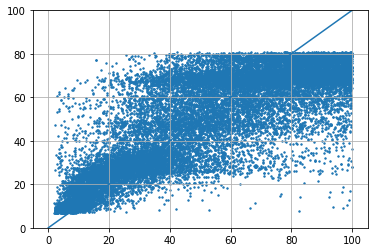

In [20]:
fig, ax = plt.subplots()
line = [0, 100]
ax.plot(line, line)
ax.scatter(visual['pt'], 
           visual['pt_pred'], 
#            c = visual['eta_median'], 
           cmap = 'copper', 
           s = 2, alpha = 1)
plt.ylim(0, 100)
ax.grid(True)

## Bias and Resolution

In [24]:
points = range(2, 100)
bias = []
resolution = []

In [25]:
for i in points:
    temp = visual[(visual['pt']>i) & (visual['pt']<i+1)]
    bias.append(temp['delta_1/pt'].mean())
    resolution.append(temp['delta_1/pt'].std())
#     resolution.append((temp['delta_1/pt'].max() - temp['delta_1/pt'].min())/2)

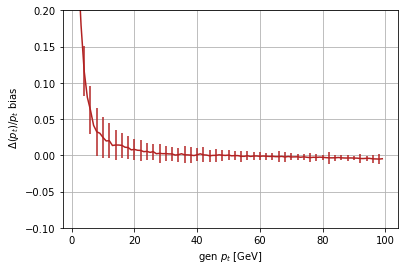

In [29]:
fig, ax = plt.subplots()
ax.errorbar(points, bias, color='firebrick', yerr=resolution, errorevery=2)
plt.ylim(-0.1, 0.2)
ax.set(xlabel=r'gen $p_t$ [GeV]', ylabel=r' $\Delta(p_t)/p_t$ bias')
ax.grid(True)
# ax.set_title('all errorbars')
fig.savefig('9s_me0.jpg', format='jpg', dpi=900)

# NN

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [13]:
X.shape

(110779, 57)

In [14]:
# 搭建模型
def create_model():
    classifier = Sequential()
    # 输入层及第一个隐藏层
    classifier.add(Dense(activation="tanh", 
                         input_dim=57, 
                         units=80, 
                         kernel_initializer="uniform"))
    # 第二个隐藏层
    classifier.add(Dense(activation="tanh", 
                         units=50, 
                         kernel_initializer="uniform"))
    # 第三个隐藏层
    classifier.add(Dense(activation="tanh", 
                         units=30, 
                         kernel_initializer="uniform"))
    # 输出层
    classifier.add(Dense(activation="tanh", 
                         units=1, 
                         kernel_initializer="uniform"))
    
    classifier.compile(optimizer = 'adam', 
                       loss = 'mse', 
                       metrics = ['mse'])
    return classifier

model = KerasRegressor(build_fn=create_model)

In [15]:
model.fit(X_train,
          y_train['pt_s'], 
          validation_data = (X_test, y_test['pt_s']),
          batch_size=5, 
          epochs = 20)

Train on 88623 samples, validate on 22156 samples
Epoch 1/20
88623/88623 [==============================] - 36s 409us/step - loss: 0.3307 - mean_squared_error: 0.3307 - val_loss: 0.3314 - val_mean_squared_error: 0.3314
Epoch 2/20
88623/88623 [==============================] - 33s 371us/step - loss: 0.2760 - mean_squared_error: 0.2760 - val_loss: 0.2196 - val_mean_squared_error: 0.2196
Epoch 3/20
88623/88623 [==============================] - 30s 342us/step - loss: 0.1888 - mean_squared_error: 0.1888 - val_loss: 0.1599 - val_mean_squared_error: 0.1599
Epoch 4/20
88623/88623 [==============================] - 31s 345us/step - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1292 - val_mean_squared_error: 0.1292
Epoch 5/20
88623/88623 [==============================] - 31s 345us/step - loss: 0.1388 - mean_squared_error: 0.1388 - val_loss: 0.1353 - val_mean_squared_error: 0.1353
Epoch 6/20
88623/88623 [==============================] - 32s 364us/step - loss: 0.1322 - mean_squared_er

In [16]:
y_pred = model.predict(X_test)

# Save Results

In [28]:
visual.to_csv('result_9s_me0_run1.csv')

Run 1: predict pt, epoch 20, batch 5, mse, tanh